In [1]:
import gurobipy as gp
import numpy as np
import pandas as pd
from scipy import stats


from gurobi_implementation import GurobiSolution
from data_market import Seller, MarketOperator, Market, Buyer
from p2p_gurobi import Agents, FirstStageMarket

In [2]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [3]:
connection_matrix = [[0, 1, 1, 1, 1],
                    [1, 0, 1, 1, 1],
                    [1, 1, 0, 1, 1],
                    [1, 1, 1, 0, 1],
                    [1, 1, 1, 1, 0]]

kappa = [[0, 10, 10, 10, 10],
        [10, 0, 10, 10, 10],
        [10, 10, 0, 10, 10],
        [10, 10, 10, 0, 10],
        [10, 10, 10, 10, 0]]    

#kappa = [[1 for i in range(5)] for k in range(5)]               

In [4]:
#model_1
actual_generations = [3, 4, 5, 4, 3]
demand = [6, 7, 8, 9, 10]

price_da_buy = 3
price_da_sell = 2
price_rt_buy = 4
price_rt_sell = 1

base_forecasts = [stats.norm(loc = generation, scale = 2.0) for generation in actual_generations]

agents_forecasts = []
for base_forecast in base_forecasts:
    probas, values = np.histogram(base_forecast.rvs(100000), bins = 100, density = True)
    probas = probas / probas.sum()
    agents_forecasts.append((probas, values))

agents = []
for id, actual_generation in enumerate(actual_generations):
    agent = Agents(id = id,
                probabilities = agents_forecasts[id][0],
                generation_values = agents_forecasts[id][1],
                demand = demand[id],
                connections = connection_matrix[id],
                kappa = kappa[id])

    agents.append(agent)

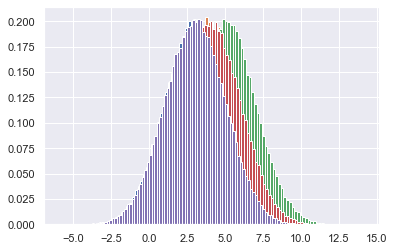

In [5]:
for i in range(5):
    plt.hist(base_forecasts[i].rvs(100000), bins = 100, density = True);

In [6]:
model_1 = gp.Model()

In [7]:
market_1 = FirstStageMarket(agents= agents,
                            model = model_1,
                            price_da_buy = price_da_buy,
                            price_da_sell = price_da_sell,
                            price_rt_buy = price_rt_buy,
                            price_rt_sell = price_rt_sell)

In [8]:
market_1.build_model()

In [9]:
model_1.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 499 rows, 983 columns and 2435 nonzeros
Model fingerprint: 0xe00c1eb0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 3e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [5e-03, 2e+01]
Presolve removed 20 rows and 10 columns
Presolve time: 0.01s
Presolved: 479 rows, 973 columns, 2395 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     762    7.5188182e+01   0.000000e+00   0.000000e+00      0s

Solved in 762 iterations and 0.01 seconds (0.01 work units)
Optimal objective  7.518818216e+01


In [10]:
def second_stage_resolution(model, agents, actual_generations):
    second_stage_decisions = []
    actual_costs = []
    for agent in agents:
        second_stage_decision = (agent.demand 
                                - actual_generations[agent.id] 
                                - model.getVarByName(f'Agent {agent.id} day-ahead purchase').X
                                + model.getVarByName(f'Agent {agent.id} day-ahead sale').X
                                - model.getVarByName(f'Agent {agent.id} net trading').X)

        second_stage_cost = price_rt_buy * second_stage_decision if second_stage_decision > 0 else price_rt_sell * second_stage_decision

        second_stage_decisions.append(second_stage_decision)

        actual_cost = (price_da_buy * model.getVarByName(f'Agent {agent.id} day-ahead purchase').X 
                    - price_da_sell * model.getVarByName(f'Agent {agent.id} day-ahead sale').X
                    + second_stage_cost)


        actual_costs.append(actual_cost)

    return second_stage_decisions, actual_costs
        

In [11]:
second_stage_resolution(model_1, agents, actual_generations)

([0.8667586549649045,
  0.7677570273804513,
  0.8560060235375033,
  0.8227955563089715,
  0.8240987823420163],
 [3.467034619859618,
  3.071028109521805,
  3.4240240941500133,
  53.87893409163435,
  3.296395129368065])

In [12]:
sum(second_stage_resolution(model_1, agents, actual_generations)[1])

67.13741604453385

In [13]:
#model_2
actual_generations = [3, 4, 5, 4, 3]
demand = [6, 7, 8, 9, 10]

price_da_buy = 3
price_da_sell = 2
price_rt_buy = 4
price_rt_sell = 1

base_forecasts = [stats.norm(loc = generation, scale = 1.0) for generation in actual_generations]

agents_forecasts = []
for base_forecast in base_forecasts:
    probas, values = np.histogram(base_forecast.rvs(100000), bins = 100, density = True)
    probas = probas / probas.sum()
    agents_forecasts.append((probas, values))

agents = []
for id, actual_generation in enumerate(actual_generations):
    agent = Agents(id = id,
                probabilities = agents_forecasts[id][0],
                generation_values = agents_forecasts[id][1],
                demand = demand[id],
                connections = connection_matrix[id],
                kappa = kappa[id])

    agents.append(agent)

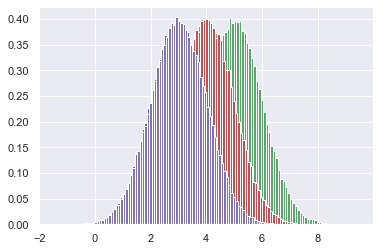

In [14]:
for i in range(5):
    plt.hist(base_forecasts[i].rvs(100000), bins = 100, density = True);

In [15]:
model_2 = gp.Model()

market_2 = FirstStageMarket(agents= agents,
                            model = model_2,
                            price_da_buy = price_da_buy,
                            price_da_sell = price_da_sell,
                            price_rt_buy = price_rt_buy,
                            price_rt_sell = price_rt_sell)

In [16]:
market_2.build_model()

In [17]:
model_2.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 506 rows, 997 columns and 2470 nonzeros
Model fingerprint: 0x1db4e204
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 3e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [2e-03, 1e+01]
Presolve removed 20 rows and 10 columns
Presolve time: 0.01s
Presolved: 486 rows, 987 columns, 2430 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     678    6.9086263e+01   0.000000e+00   0.000000e+00      0s

Solved in 678 iterations and 0.01 seconds (0.01 work units)
Optimal objective  6.908626315e+01


In [18]:
second_stage_resolution(model_2, agents, actual_generations)

([0.3619776299794166,
  0.4222321019371087,
  0.4119068292668828,
  0.39990153089453706,
  0.34482771185261196],
 [1.4479105199176665,
  58.86639099595676,
  1.6476273170675313,
  1.5996061235781482,
  1.3793108474104478])

In [19]:
sum(second_stage_resolution(model_2, agents, actual_generations)[1])

64.94084580393056

In [20]:
#model_3
actual_generations = [3, 4, 5, 4, 3]
demand = [6, 7, 8, 9, 10]

price_da_buy = 3
price_da_sell = 2
price_rt_buy = 4
price_rt_sell = 1

base_forecasts = [stats.norm(loc = generation, scale = 0.2) for generation in actual_generations]

agents_forecasts = []
for base_forecast in base_forecasts:
    probas, values = np.histogram(base_forecast.rvs(100000), bins = 100, density = True)
    probas = probas / probas.sum()
    agents_forecasts.append((probas, values))

agents = []
for id, actual_generation in enumerate(actual_generations):
    agent = Agents(id = id,
                probabilities = agents_forecasts[id][0],
                generation_values = agents_forecasts[id][1],
                demand = demand[id],
                connections = connection_matrix[id],
                kappa = kappa[id])

    agents.append(agent)

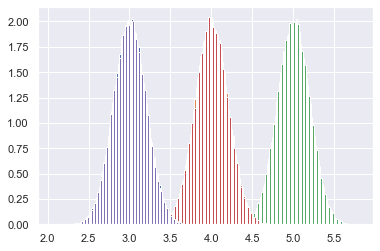

In [21]:
for i in range(5):
    plt.hist(base_forecasts[i].rvs(100000), bins = 100, density = True);

In [22]:
model_3 = gp.Model()

market_3 = FirstStageMarket(agents= agents,
                            model = model_3,
                            price_da_buy = price_da_buy,
                            price_da_sell = price_da_sell,
                            price_rt_buy = price_rt_buy,
                            price_rt_sell = price_rt_sell)

In [23]:
market_3.build_model()
model_3.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 507 rows, 999 columns and 2475 nonzeros
Model fingerprint: 0x223ea1ef
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 3e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [2e+00, 8e+00]
Presolve removed 20 rows and 10 columns
Presolve time: 0.01s
Presolved: 487 rows, 989 columns, 2435 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     738    6.4226757e+01   0.000000e+00   0.000000e+00      0s

Solved in 738 iterations and 0.01 seconds (0.01 work units)
Optimal objective  6.422675730e+01


In [24]:
second_stage_resolution(model_3, agents, actual_generations)

([0.0762759224531635,
  0.0829993527378079,
  0.06921010779316639,
  0.07746707173176226,
  0.07862885617907178],
 [62.151359757127736,
  0.3319974109512316,
  0.27684043117266555,
  0.30986828692704904,
  0.31451542471628713])

In [25]:
sum(second_stage_resolution(model_3, agents, actual_generations)[1])

63.38458131089497

In [26]:
#model_4
actual_generations = [3, 4, 5, 4, 3]
demand = [6, 7, 8, 9, 10]

price_da_buy = 3
price_da_sell = 2
price_rt_buy = 4
price_rt_sell = 1

base_forecasts = [stats.norm(loc = generation, scale = 0.0) for generation in actual_generations]

agents_forecasts = []
for base_forecast in base_forecasts:
    probas, values = np.histogram(base_forecast.rvs(100000), bins = 100, density = True)
    probas = probas / probas.sum()
    agents_forecasts.append((probas, values))

agents = []
for id, actual_generation in enumerate(actual_generations):
    agent = Agents(id = id,
                probabilities = agents_forecasts[id][0],
                generation_values = agents_forecasts[id][1],
                demand = demand[id],
                connections = connection_matrix[id],
                kappa = kappa[id])

    agents.append(agent)

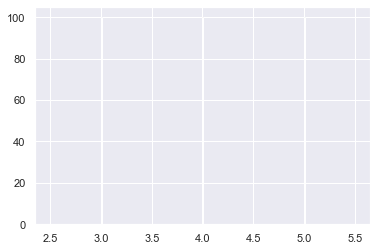

In [27]:
for i in range(5):
    plt.hist(base_forecasts[i].rvs(100000), bins = 100, density = True);

In [28]:
model_4 = gp.Model()

market_4 = FirstStageMarket(agents= agents,
                            model = model_4,
                            price_da_buy = price_da_buy,
                            price_da_sell = price_da_sell,
                            price_rt_buy = price_rt_buy,
                            price_rt_sell = price_rt_sell)

market_4.build_model()
model_4.optimize()                            

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 30 rows, 45 columns and 90 nonzeros
Model fingerprint: 0x803f6299
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [3e+00, 7e+00]
Presolve removed 25 rows and 20 columns
Presolve time: 0.00s
Presolved: 5 rows, 25 columns, 35 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5000000e+02   3.925000e+01   0.000000e+00      0s
       9    6.3000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.300000000e+01


In [29]:
second_stage_resolution(model_4, agents, actual_generations)

([0.0, 0.0, 0.0, 0.0, 0.0], [39.0, 9.0, 0.0, 15.0, 0.0])

In [30]:
sum(second_stage_resolution(model_4, agents, actual_generations)[1])

63.0

In [31]:
print('Model_1 net trades:', [model_1.getVarByName(f'Agent {id} net trading').X for id, _ in enumerate(agents)])
print('Model_2 net trades:', [model_2.getVarByName(f'Agent {id} net trading').X for id, _ in enumerate(agents)])
print('Model_3 net trades:', [model_3.getVarByName(f'Agent {id} net trading').X for id, _ in enumerate(agents)])
print('Model_4 net trades:', [model_4.getVarByName(f'Agent {id} net trading').X for id, _ in enumerate(agents)])

Model_1 net trades: [2.1332413450350955, 2.2322429726195487, 2.1439939764624967, -12.685379511775125, 6.175901217657984]
Model_2 net trades: [2.6380223700205834, -16.48138629800655, 2.588093170733117, 4.600098469105463, 6.655172288147388]
Model_3 net trades: [-17.69169461155819, 2.917000647262192, 2.9307898922068336, 4.922532928268238, 6.921371143820928]
Model_4 net trades: [-10.0, 0.0, 3.0, 0.0, 7.0]


In [32]:
duals = model_1.getAttr('Pi')

In [33]:
const_names = model_1.getConstrs()

In [34]:
for x in zip(const_names, duals):
    if str(x[0]) in [f'<gurobi.Constr Bilateral trading for pair ({a}, {b})>' for a in range(5) for b in range(5)]:
        print(x)

(<gurobi.Constr Bilateral trading for pair (0, 1)>, -3.000000000000001)
(<gurobi.Constr Bilateral trading for pair (0, 2)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (0, 3)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (0, 4)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (1, 0)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (1, 2)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (1, 3)>, -3.000000000000001)
(<gurobi.Constr Bilateral trading for pair (1, 4)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (2, 0)>, -3.000000000000001)
(<gurobi.Constr Bilateral trading for pair (2, 1)>, -3.000000000000001)
(<gurobi.Constr Bilateral trading for pair (2, 3)>, -3.000000000000001)
(<gurobi.Constr Bilateral trading for pair (2, 4)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (3, 0)>, -3.000000000000001)
(<gurobi.Constr Bilateral trading for pair (3, 1)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (3, 2)>, 0.0)
(<gurobi.Constr Bilateral trading for pair (3, 4)>, 0.0

In [35]:
def trading_costs(agents, model):
    res = []
    duals = model.getAttr('Pi')
    const_names = model.getConstrs()

    for agent in agents:
        agent_trading_cost = 0
        for x in zip(const_names, duals):
            for agent_2 in agents:
                if str(x[0]) == f'<gurobi.Constr Bilateral trading for pair ({agent.id}, {agent_2.id})>':
                    print(f'q_{agent.id}_{agent_2.id}:', x[1], model.getVarByName(f'q_{agent.id}_{agent_2.id}').X)
                    agent_trading_cost += x[1] * model.getVarByName(f'q_{agent.id}_{agent_2.id}').X

        res.append(agent_trading_cost)

    return res

In [36]:
trading_costs(agents, model_1)

q_0_1: -3.000000000000001 -7.8667586549649045
q_0_2: 0.0 -10.0
q_0_3: 0.0 10.0
q_0_4: 0.0 10.0
q_1_0: 0.0 7.8667586549649045
q_1_2: 0.0 -10.0
q_1_3: -3.000000000000001 10.0
q_1_4: 0.0 -5.634515682345356
q_2_0: -3.000000000000001 10.0
q_2_1: -3.000000000000001 10.0
q_2_3: -3.000000000000001 -10.0
q_2_4: 0.0 -7.856006023537503
q_3_0: -3.000000000000001 -10.0
q_3_1: 0.0 -10.0
q_3_2: 0.0 10.0
q_3_4: 0.0 -2.6853795117751247
q_4_0: -3.000000000000001 -10.0
q_4_1: -3.000000000000001 5.634515682345356
q_4_2: -3.000000000000001 7.856006023537503
q_4_3: -3.000000000000001 2.6853795117751247


[23.60027596489472,
 -30.000000000000007,
 -30.000000000000007,
 30.000000000000007,
 -18.527703652973955]

In [37]:
sum(np.array(trading_costs(agents, model_1)) + np.array(second_stage_resolution(model_1, agents, actual_generations)[1]))

q_0_1: -3.000000000000001 -7.8667586549649045
q_0_2: 0.0 -10.0
q_0_3: 0.0 10.0
q_0_4: 0.0 10.0
q_1_0: 0.0 7.8667586549649045
q_1_2: 0.0 -10.0
q_1_3: -3.000000000000001 10.0
q_1_4: 0.0 -5.634515682345356
q_2_0: -3.000000000000001 10.0
q_2_1: -3.000000000000001 10.0
q_2_3: -3.000000000000001 -10.0
q_2_4: 0.0 -7.856006023537503
q_3_0: -3.000000000000001 -10.0
q_3_1: 0.0 -10.0
q_3_2: 0.0 10.0
q_3_4: 0.0 -2.6853795117751247
q_4_0: -3.000000000000001 -10.0
q_4_1: -3.000000000000001 5.634515682345356
q_4_2: -3.000000000000001 7.856006023537503
q_4_3: -3.000000000000001 2.6853795117751247


42.209988356454616

In [38]:
sum(np.array(trading_costs(agents, model_2)) + np.array(second_stage_resolution(model_2, agents, actual_generations)[1]))

q_0_1: 0.0 10.0
q_0_2: 0.0 10.0
q_0_3: 0.0 -7.361977629979417
q_0_4: 0.0 -10.0
q_1_0: -3.000000000000001 -10.0
q_1_2: 0.0 -10.0
q_1_3: -3.000000000000001 -6.481386298006552
q_1_4: 0.0 10.0
q_2_0: -3.000000000000001 -10.0
q_2_1: -3.000000000000001 10.0
q_2_3: -3.000000000000001 10.0
q_2_4: 0.0 -7.411906829266883
q_3_0: -3.000000000000001 7.3619776299794175
q_3_1: 0.0 6.4813862980065515
q_3_2: 0.0 -10.0
q_3_4: 0.0 0.7567345411194957
q_4_0: -3.000000000000001 10.0
q_4_1: -3.000000000000001 -10.0
q_4_2: -3.000000000000001 7.411906829266883
q_4_3: -3.000000000000001 -0.7567345411194957


42.3335549435698

In [39]:
sum(np.array(trading_costs(agents, model_3)) + np.array(second_stage_resolution(model_3, agents, actual_generations)[1]))

q_0_1: -3.0 -7.691694611558192
q_0_2: -3.0 10.0
q_0_3: -3.0 -10.0
q_0_4: 0.0 -10.0
q_1_0: 0.0 7.691694611558191
q_1_2: 0.0 7.069210107793168
q_1_3: -3.0 -10.0
q_1_4: 0.0 -1.8439040720891668
q_2_0: 0.0 -10.0
q_2_1: -3.0 -7.069210107793166
q_2_3: -3.0 10.0
q_2_4: 0.0 10.0
q_3_0: 0.0 10.0
q_3_1: 0.0 10.0
q_3_2: 0.0 -10.0
q_3_4: 0.0 -5.077467071731762
q_4_0: -3.0 10.0
q_4_1: -3.0 1.8439040720891668
q_4_2: -3.0 -10.0
q_4_3: -3.0 5.077467071731762


86.90318203748626

In [40]:
sum(np.array(trading_costs(agents, model_4)) + np.array(second_stage_resolution(model_4, agents, actual_generations)[1]))

q_0_1: -3.0 -10.0
q_0_2: 0.0 0.0
q_0_3: -3.0 10.0
q_0_4: -3.0 -10.0
q_1_0: 0.0 10.0
q_1_2: -3.0 10.0
q_1_3: -3.0 -10.0
q_1_4: 0.0 -10.0
q_2_0: -3.0 0.0
q_2_1: 0.0 -10.0
q_2_3: -3.0 10.0
q_2_4: 0.0 3.0
q_3_0: 0.0 -10.0
q_3_1: 0.0 10.0
q_3_2: 0.0 -10.0
q_3_4: -3.0 10.0
q_4_0: 0.0 10.0
q_4_1: -3.0 10.0
q_4_2: -3.0 -3.0
q_4_3: 0.0 -10.0


12.0

In [41]:
model_4.getVars()

[<gurobi.Var Agent 0 day-ahead purchase (value 13.0)>,
 <gurobi.Var Agent 0 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 0 proba 50 real-time purchase (value 0.0)>,
 <gurobi.Var Agent 0 proba 50 real-time sale (value 0.0)>,
 <gurobi.Var q_0_1 (value -10.0)>,
 <gurobi.Var q_0_2 (value 0.0)>,
 <gurobi.Var q_0_3 (value 10.0)>,
 <gurobi.Var q_0_4 (value -10.0)>,
 <gurobi.Var Agent 0 net trading (value -10.0)>,
 <gurobi.Var Agent 1 day-ahead purchase (value 3.0)>,
 <gurobi.Var Agent 1 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 1 proba 50 real-time purchase (value 0.0)>,
 <gurobi.Var Agent 1 proba 50 real-time sale (value 0.0)>,
 <gurobi.Var q_1_0 (value 10.0)>,
 <gurobi.Var q_1_2 (value 10.0)>,
 <gurobi.Var q_1_3 (value -10.0)>,
 <gurobi.Var q_1_4 (value -10.0)>,
 <gurobi.Var Agent 1 net trading (value 0.0)>,
 <gurobi.Var Agent 2 day-ahead purchase (value 0.0)>,
 <gurobi.Var Agent 2 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 2 proba 50 real-time purchase (value 0.0)>,
 <gurobi.

In [42]:
model_4.getObjective()

<gurobi.LinExpr: 3.0 Agent 0 day-ahead purchase + -2.0 Agent 0 day-ahead sale + 4.0 Agent 0 proba 50 real-time purchase + -1.0 Agent 0 proba 50 real-time sale + 3.0 Agent 1 day-ahead purchase + -2.0 Agent 1 day-ahead sale + 4.0 Agent 1 proba 50 real-time purchase + -1.0 Agent 1 proba 50 real-time sale + 3.0 Agent 2 day-ahead purchase + -2.0 Agent 2 day-ahead sale + 4.0 Agent 2 proba 50 real-time purchase + -1.0 Agent 2 proba 50 real-time sale + 3.0 Agent 3 day-ahead purchase + -2.0 Agent 3 day-ahead sale + 4.0 Agent 3 proba 50 real-time purchase + -1.0 Agent 3 proba 50 real-time sale + 3.0 Agent 4 day-ahead purchase + -2.0 Agent 4 day-ahead sale + 4.0 Agent 4 proba 50 real-time purchase + -1.0 Agent 4 proba 50 real-time sale>

In [43]:
model_4.display()

Minimize
<gurobi.LinExpr: 3.0 Agent 0 day-ahead purchase + -2.0 Agent 0 day-ahead sale
+ 4.0 Agent 0 proba 50 real-time purchase + -1.0 Agent 0 proba 50 real-time sale
+ 3.0 Agent 1 day-ahead purchase + -2.0 Agent 1 day-ahead sale
+ 4.0 Agent 1 proba 50 real-time purchase + -1.0 Agent 1 proba 50 real-time sale
+ 3.0 Agent 2 day-ahead purchase + -2.0 Agent 2 day-ahead sale
+ 4.0 Agent 2 proba 50 real-time purchase + -1.0 Agent 2 proba 50 real-time sale
+ 3.0 Agent 3 day-ahead purchase + -2.0 Agent 3 day-ahead sale
+ 4.0 Agent 3 proba 50 real-time purchase + -1.0 Agent 3 proba 50 real-time sale
+ 3.0 Agent 4 day-ahead purchase + -2.0 Agent 4 day-ahead sale
+ 4.0 Agent 4 proba 50 real-time purchase + -1.0 Agent 4 proba 50 real-time sale>
Subject To
Net trading constraint: <gurobi.LinExpr: -1.0 q_0_1 + -1.0 q_0_2 + -1.0 q_0_3 + -1.0
 q_0_4 + Agent 0 net trading> = 0
SD balance for agent 0 proba 50: <gurobi.LinExpr: -1.0 Agent 0 day-ahead purchase +
Agent 0 day-ahead sale + -1.0 Agent 0 pro

In [44]:
model_4.getVars()

[<gurobi.Var Agent 0 day-ahead purchase (value 13.0)>,
 <gurobi.Var Agent 0 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 0 proba 50 real-time purchase (value 0.0)>,
 <gurobi.Var Agent 0 proba 50 real-time sale (value 0.0)>,
 <gurobi.Var q_0_1 (value -10.0)>,
 <gurobi.Var q_0_2 (value 0.0)>,
 <gurobi.Var q_0_3 (value 10.0)>,
 <gurobi.Var q_0_4 (value -10.0)>,
 <gurobi.Var Agent 0 net trading (value -10.0)>,
 <gurobi.Var Agent 1 day-ahead purchase (value 3.0)>,
 <gurobi.Var Agent 1 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 1 proba 50 real-time purchase (value 0.0)>,
 <gurobi.Var Agent 1 proba 50 real-time sale (value 0.0)>,
 <gurobi.Var q_1_0 (value 10.0)>,
 <gurobi.Var q_1_2 (value 10.0)>,
 <gurobi.Var q_1_3 (value -10.0)>,
 <gurobi.Var q_1_4 (value -10.0)>,
 <gurobi.Var Agent 1 net trading (value 0.0)>,
 <gurobi.Var Agent 2 day-ahead purchase (value 0.0)>,
 <gurobi.Var Agent 2 day-ahead sale (value 0.0)>,
 <gurobi.Var Agent 2 proba 50 real-time purchase (value 0.0)>,
 <gurobi.

In [45]:
print(np.array(second_stage_resolution(model_1, agents, actual_generations)[0]))
print(np.array(second_stage_resolution(model_2, agents, actual_generations)[0]))
print(np.array(second_stage_resolution(model_3, agents, actual_generations)[0]))
print(np.array(second_stage_resolution(model_4, agents, actual_generations)[0]))

[0.86675865 0.76775703 0.85600602 0.82279556 0.82409878]
[0.36197763 0.4222321  0.41190683 0.39990153 0.34482771]
[0.07627592 0.08299935 0.06921011 0.07746707 0.07862886]
[0. 0. 0. 0. 0.]


In [46]:
print('Model_1 net trades:', [model_1.getVarByName(f'Agent {id} net trading').X for id, _ in enumerate(agents)])
print('Model_2 net trades:', [model_2.getVarByName(f'Agent {id} net trading').X for id, _ in enumerate(agents)])
print('Model_3 net trades:', [model_3.getVarByName(f'Agent {id} net trading').X for id, _ in enumerate(agents)])
print('Model_4 net trades:', [model_4.getVarByName(f'Agent {id} net trading').X for id, _ in enumerate(agents)])

Model_1 net trades: [2.1332413450350955, 2.2322429726195487, 2.1439939764624967, -12.685379511775125, 6.175901217657984]
Model_2 net trades: [2.6380223700205834, -16.48138629800655, 2.588093170733117, 4.600098469105463, 6.655172288147388]
Model_3 net trades: [-17.69169461155819, 2.917000647262192, 2.9307898922068336, 4.922532928268238, 6.921371143820928]
Model_4 net trades: [-10.0, 0.0, 3.0, 0.0, 7.0]


In [47]:
print(np.array(second_stage_resolution(model_1, agents, actual_generations)[1]))
print(np.array(second_stage_resolution(model_2, agents, actual_generations)[1]))
print(np.array(second_stage_resolution(model_3, agents, actual_generations)[1]))
print(np.array(second_stage_resolution(model_4, agents, actual_generations)[1]))

[ 3.46703462  3.07102811  3.42402409 53.87893409  3.29639513]
[ 1.44791052 58.866391    1.64762732  1.59960612  1.37931085]
[62.15135976  0.33199741  0.27684043  0.30986829  0.31451542]
[39.  9.  0. 15.  0.]


In [48]:
print(np.array(second_stage_resolution(model_1, agents, actual_generations)[1]).sum())
print(np.array(second_stage_resolution(model_2, agents, actual_generations)[1]).sum())
print(np.array(second_stage_resolution(model_3, agents, actual_generations)[1]).sum())
print(np.array(second_stage_resolution(model_4, agents, actual_generations)[1]).sum())

67.13741604453385
64.94084580393056
63.38458131089497
63.0


In [49]:
total_costs = [np.array(second_stage_resolution(model_1, agents, actual_generations)[1]).sum(),
            np.array(second_stage_resolution(model_2, agents, actual_generations)[1]).sum(),
            np.array(second_stage_resolution(model_3, agents, actual_generations)[1]).sum(),
            np.array(second_stage_resolution(model_4, agents, actual_generations)[1]).sum()]

In [50]:
variance = [2.0, 1.0, 0.5, 0.0]

In [51]:
for i in range(4):
    print(variance[i], total_costs[i])

2.0 67.13741604453385
1.0 64.94084580393056
0.5 63.38458131089497
0.0 63.0


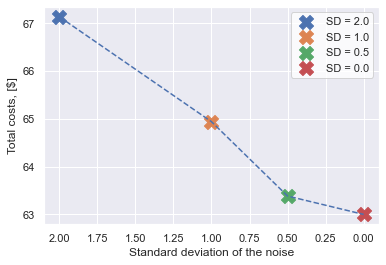

In [52]:
fig, plot = plt.subplots()
sns.set_style('white')

for i in range(4):
    plt.scatter(variance[i], total_costs[i], marker = 'X', s= 200, label = f'SD = {variance[i]}');

plt.plot(variance, total_costs, linestyle='dashed')

plt.legend()
plt.ylabel('Total costs, [\$]', fontsize = 12)
plt.xlabel('Standard deviation of the noise', fontsize = 12)
#plt.vlines([2.0, 1.0, 0.5, 0.0], 63, 67, linestyles='dashed', colors='gray')
plot.invert_xaxis();

In [53]:
sns.swarmplot(x = [0,1,2,3,4,5], y = [sum_RN, sum_without_contracts, sum_only_IC, sum_no_IC, sum_opt, sum_pes], marker = markers[i % 5], s = 12, linewidth=1)


NameError: name 'sum_RN' is not defined